In [1]:
# import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# import data
# 2024 Jan - July
# Yellow Taxi
jan_data = 'data/yellow_tripdata_2024-01.parquet'
feb_data = 'data/yellow_tripdata_2024-02.parquet'
mar_data = 'data/yellow_tripdata_2024-03.parquet'
apr_data = 'data/yellow_tripdata_2024-04.parquet'
may_data = 'data/yellow_tripdata_2024-05.parquet'
jun_data = 'data/yellow_tripdata_2024-06.parquet'
jul_data = 'data/yellow_tripdata_2024-07.parquet'

data_1 = pd.read_parquet(jan_data)
data_2 = pd.read_parquet(feb_data)
data_3 = pd.read_parquet(mar_data)
data_4 = pd.read_parquet(apr_data)
data_5 = pd.read_parquet(may_data)
data_6 = pd.read_parquet(jun_data)
data_7 = pd.read_parquet(jul_data)

data_1

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [3]:
data_1.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [4]:
# merge taxi data into one
data_1['month'] = '1'
data_2['month'] = '2'
data_3['month'] = '3'
data_4['month'] = '4'
data_5['month'] = '5'
data_6['month'] = '6'
data_7['month'] = '7'

taxi_df = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6, data_7], ignore_index=True)

# delete NaN
taxi_df = taxi_df.dropna(how='any')

taxi_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,month
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0,1
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,1
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0,1
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0,1
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23130002,2,2024-07-31 23:21:07,2024-07-31 23:29:37,1.0,1.76,1.0,N,249,137,1,10.7,1.0,0.5,3.14,0.0,1.0,18.84,2.5,0.0,7
23130003,2,2024-07-31 23:45:49,2024-07-31 23:50:53,2.0,1.17,1.0,N,137,229,1,7.9,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.0,7
23130004,1,2024-07-31 23:09:10,2024-07-31 23:15:54,2.0,0.60,1.0,N,163,230,1,7.9,3.5,0.5,3.85,0.0,1.0,16.75,2.5,0.0,7
23130005,1,2024-07-31 23:42:32,2024-08-01 00:05:49,2.0,4.30,1.0,N,43,231,1,24.0,3.5,0.5,5.80,0.0,1.0,34.80,2.5,0.0,7


In [5]:
# add day of week column
taxi_df['day_of_week'] = pd.to_datetime(taxi_df['tpep_pickup_datetime']).dt.dayofweek
set(taxi_df['day_of_week'].values)

{0, 1, 2, 3, 4, 5, 6}

<Axes: >

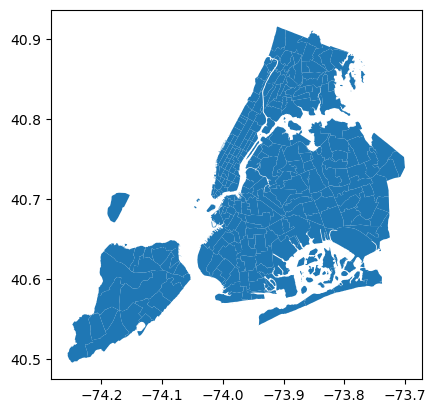

In [6]:
# zone shp file import
zones = gpd.read_file('/Users/kweon-youngseo/Downloads/NYC Taxi Zones/geo_export_5af2cbc2-dead-46f8-9eca-86a3265a8aca.shp')
zones.plot()

In [7]:
# find manhattan location id
zones_m = zones[zones['borough'] == 'Manhattan']

manhattan_location_ids = zones_m['location_i'].tolist()

In [8]:
# sort trips - org and dest both manhattan
m_taxi_data = taxi_df[
    (taxi_df['PULocationID'].isin(manhattan_location_ids)) & 
    (taxi_df['DOLocationID'].isin(manhattan_location_ids))
]

m_taxi_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,month,day_of_week
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,...,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0,1,0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,...,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,1,0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,...,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0,1,0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,...,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0,1,0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,...,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23130002,2,2024-07-31 23:21:07,2024-07-31 23:29:37,1.0,1.76,1.0,N,249,137,1,...,1.0,0.5,3.14,0.0,1.0,18.84,2.5,0.0,7,2
23130003,2,2024-07-31 23:45:49,2024-07-31 23:50:53,2.0,1.17,1.0,N,137,229,1,...,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.0,7,2
23130004,1,2024-07-31 23:09:10,2024-07-31 23:15:54,2.0,0.60,1.0,N,163,230,1,...,3.5,0.5,3.85,0.0,1.0,16.75,2.5,0.0,7,2
23130005,1,2024-07-31 23:42:32,2024-08-01 00:05:49,2.0,4.30,1.0,N,43,231,1,...,3.5,0.5,5.80,0.0,1.0,34.80,2.5,0.0,7,2


In [9]:
# find O-D hotspots
origin_counts = m_taxi_data['PULocationID'].value_counts().reset_index()
origin_counts.columns = ['location_i', 'origin_count']

destination_counts = m_taxi_data['DOLocationID'].value_counts().reset_index()
destination_counts.columns = ['location_i', 'destination_count']

origin_counts

,location_i,origin_count
0,237,988394
1,161,967963
2,236,889683
3,162,723239
4,186,695163
...,...,...
61,194,607
62,202,463
63,153,165
64,128,80


In [10]:
# merge zones and counts dataframes
org_merged = zones_m.merge(origin_counts, on='location_i', how='left')
dest_merged = zones_m.merge(destination_counts, on='location_i', how='left')

# add 0 values
org_merged['origin_count'] = org_merged['origin_count'].fillna(0)
dest_merged['destination_count'] = dest_merged['destination_count'].fillna(0)

In [11]:
org_merged

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,origin_count
0,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",19652.0
1,Manhattan,24.0,24.0,0.000061,0.047000,Bloomingdale,"POLYGON ((-73.95954 40.79872, -73.96004 40.798...",48931.0
2,Manhattan,12.0,12.0,0.000042,0.036661,Battery Park,"POLYGON ((-74.01566 40.70483, -74.01540 40.704...",8222.0
3,Manhattan,13.0,13.0,0.000149,0.050281,Battery Park City,"POLYGON ((-74.01244 40.71906, -74.01282 40.717...",108400.0
4,Manhattan,41.0,41.0,0.000143,0.052793,Central Harlem,"POLYGON ((-73.94774 40.80960, -73.94506 40.808...",41425.0
...,...,...,...,...,...,...,...,...
64,Manhattan,244.0,244.0,0.000360,0.080569,Washington Heights South,"POLYGON ((-73.94069 40.85132, -73.94069 40.851...",9483.0
65,Manhattan,246.0,246.0,0.000281,0.069467,West Chelsea/Hudson Yards,"POLYGON ((-74.00440 40.76267, -74.00220 40.761...",345428.0
66,Manhattan,249.0,249.0,0.000072,0.036384,West Village,"POLYGON ((-74.00251 40.72902, -74.00282 40.728...",448495.0
67,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",93486.0


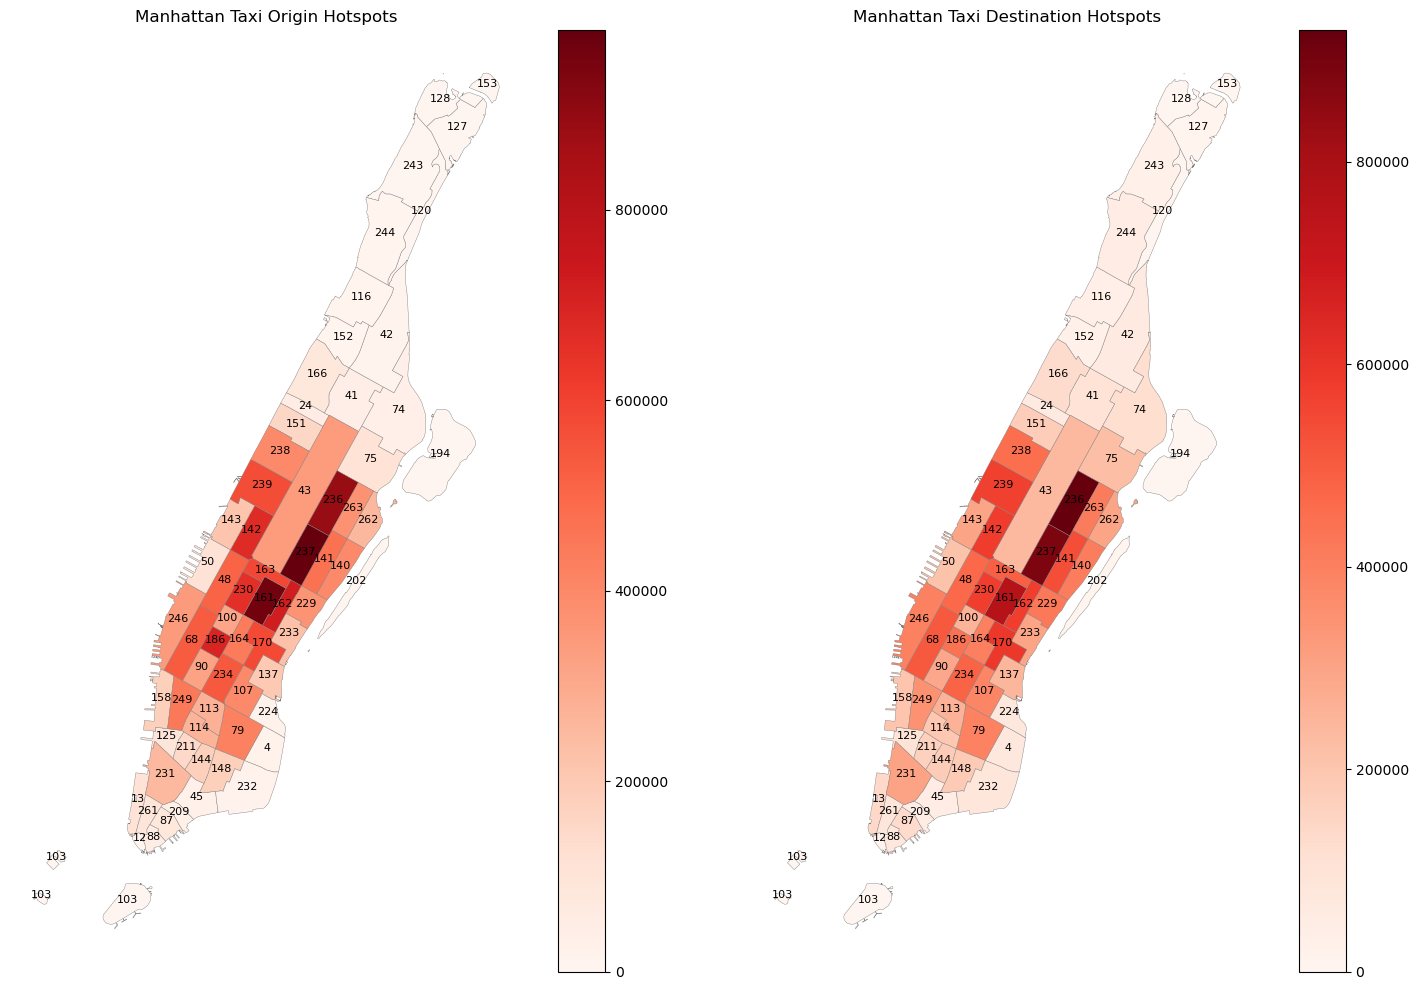

In [12]:
# plot hotspot maps
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# origin
org_merged.plot(column='origin_count', cmap='Reds', legend=True, ax=ax[0], edgecolor='grey', linewidth = 0.3)
ax[0].set_title('Manhattan Taxi Origin Hotspots')
ax[0].set_axis_off()

for idx, row in org_merged.iterrows():
    centroid = row['geometry'].centroid
    ax[0].text(centroid.x, centroid.y, str(int(row['location_i'])),
               fontsize=8, ha='center', color='black')


# destination
dest_merged.plot(column='destination_count', cmap='Reds', legend=True, ax=ax[1], edgecolor='grey', linewidth = 0.3)
ax[1].set_title('Manhattan Taxi Destination Hotspots')
ax[1].set_axis_off()

for idx, row in dest_merged.iterrows():
    centroid = row['geometry'].centroid
    ax[1].text(centroid.x, centroid.y, str(int(row['location_i'])),
               fontsize=8, ha='center', color='black')

plt.tight_layout()
plt.show()

In [13]:
# frequent routes over time - based on zones
route_counts = taxi_df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

top_routes = route_counts.nlargest(20, 'count')

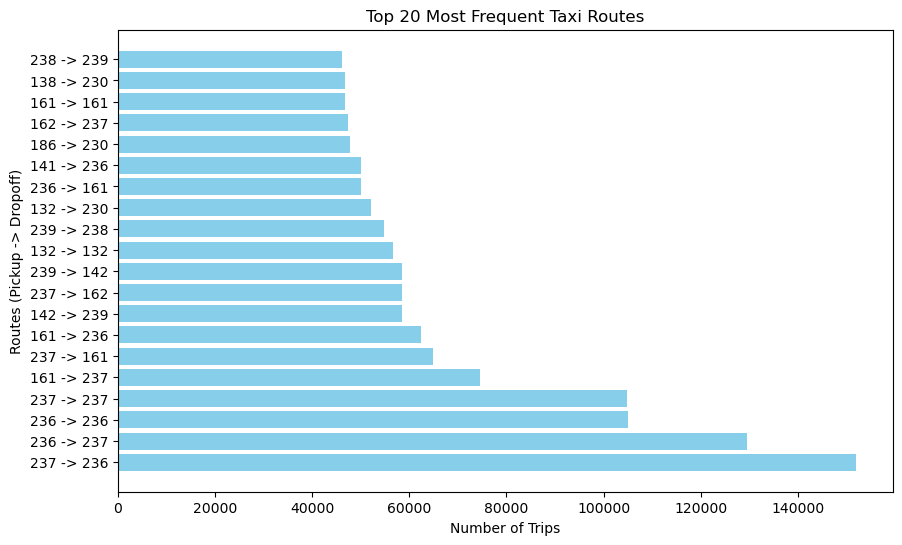

In [14]:
# visualize
plt.figure(figsize=(10, 6))
plt.barh(top_routes.apply(lambda x: f"{x['PULocationID']} -> {x['DOLocationID']}", axis=1), top_routes['count'], color='skyblue')
plt.xlabel('Number of Trips')
plt.ylabel('Routes (Pickup -> Dropoff)')
plt.title('Top 20 Most Frequent Taxi Routes')
plt.show()

In [15]:
# per time period hotspots

## define time periods
def categorize_time(hour):
    if 0 <= hour < 6:
        return 'Late Night'
    elif 6 <= hour < 9:
        return 'Morning Peak'
    elif 9 <= hour < 12:
        return 'Late Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 19:
        return 'Evening Peak'
    else:
        return 'Night'

In [16]:
# categorize
taxi_df['time_period'] = taxi_df['tpep_pickup_datetime'].dt.hour.apply(categorize_time)

In [17]:
# group by time period, pickup, and dropoff locations, and count the number of trips
route_counts_by_time = taxi_df.groupby(['time_period', 'PULocationID', 'DOLocationID']).size().reset_index(name='count')

# find the top 10 most frequent routes for each time period
top_routes_by_time = route_counts_by_time.groupby('time_period').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)

In [18]:
top_routes_by_time

,time_period,PULocationID,DOLocationID,count
0,Afternoon,237,236,48735
1,Afternoon,236,237,43183
2,Afternoon,237,237,34735
3,Afternoon,236,236,34196
4,Afternoon,161,237,23229
5,Afternoon,237,161,19980
6,Afternoon,239,142,17363
7,Afternoon,161,236,17071
8,Afternoon,237,162,16629
9,Afternoon,239,238,16309


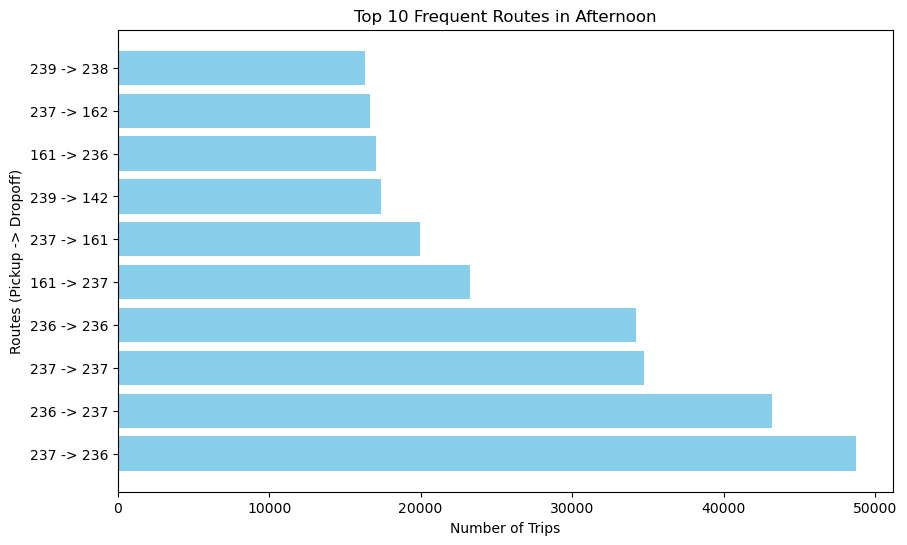

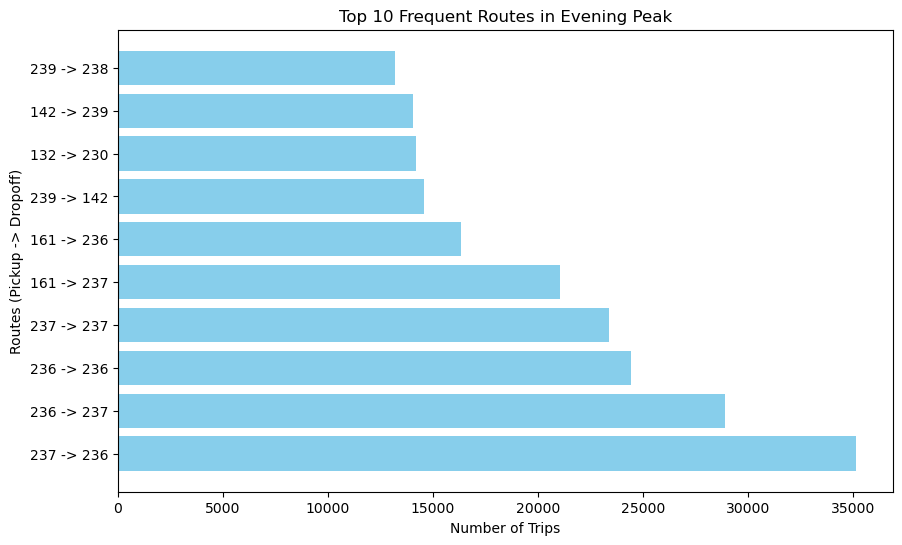

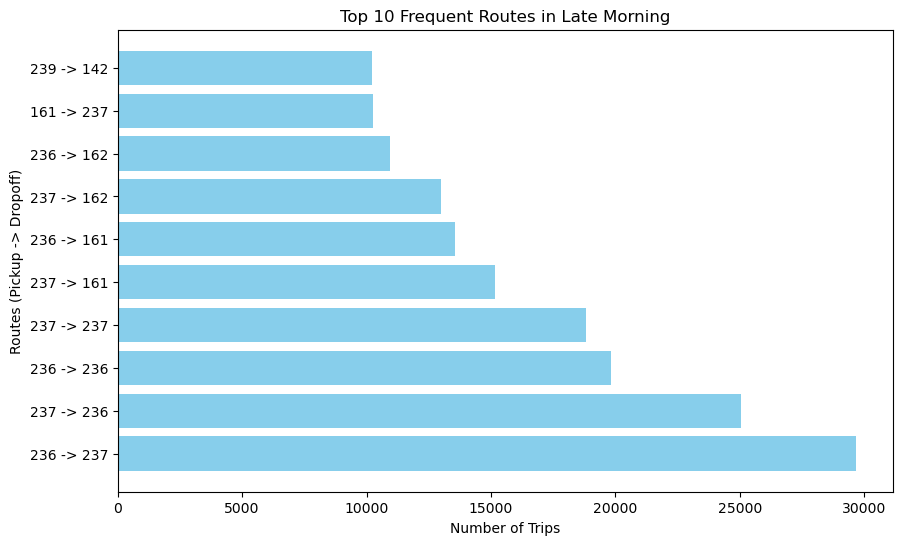

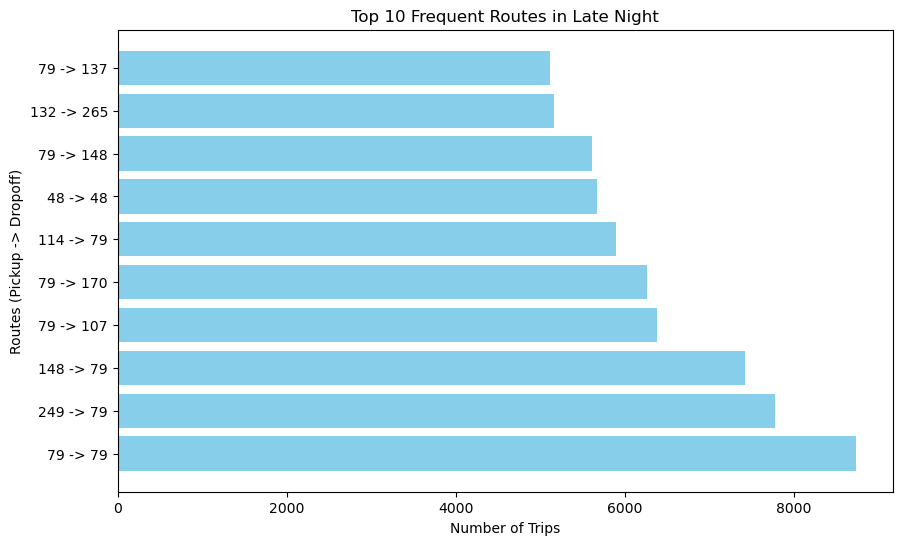

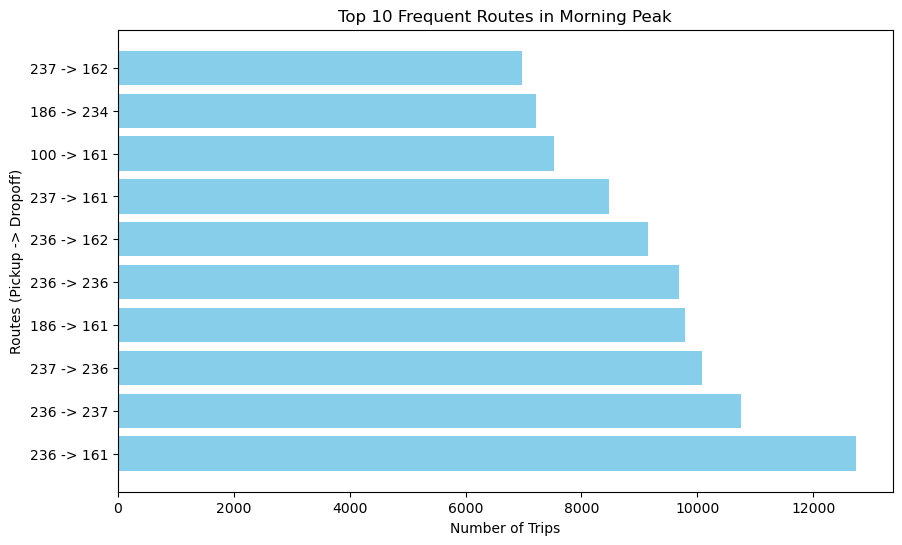

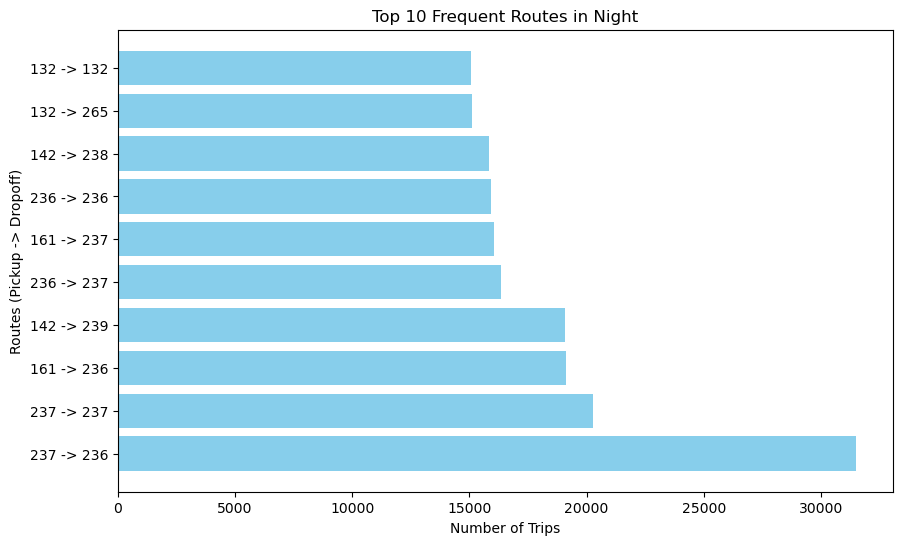

In [19]:
for time_period in top_routes_by_time['time_period'].unique():
    subset = top_routes_by_time[top_routes_by_time['time_period'] == time_period]
    plt.figure(figsize=(10, 6))
    plt.barh(subset.apply(lambda x: f"{x['PULocationID']} -> {x['DOLocationID']}", axis=1), subset['count'], color='skyblue')
    plt.title(f"Top 10 Frequent Routes in {time_period}")
    plt.xlabel('Number of Trips')
    plt.ylabel('Routes (Pickup -> Dropoff)')
    plt.show()

In [20]:
# group by origin, destination, and time period, and count trips
taxi_df_grouped = taxi_df.groupby(['PULocationID', 'DOLocationID', 'time_period']).size().reset_index(name='count')

taxi_df_grouped

,PULocationID,DOLocationID,time_period,count
0,1,1,Afternoon,1020
1,1,1,Evening Peak,795
2,1,1,Late Morning,248
3,1,1,Late Night,180
4,1,1,Morning Peak,242
...,...,...,...,...
144046,265,265,Evening Peak,1485
144047,265,265,Late Morning,942
144048,265,265,Late Night,2635
144049,265,265,Morning Peak,534


In [21]:
# train model to predict future requests
## XGBoost
X = taxi_df_grouped[['PULocationID', 'DOLocationID', 'time_period']]
y = taxi_df_grouped['count']

# convert 'time_period' into dummy/one-hot encoded columns for modeling
X = pd.get_dummies(X, columns=['time_period'])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.4, learning_rate = 0.01,
                          max_depth = 10, alpha = 10, n_estimators = 1000)

xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [22]:
# make predictions
y_pred = xg_reg.predict(X_test)

# evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 537.2747280098322


In [23]:
## LSTM
# normalize the time series data
scaler = MinMaxScaler(feature_range=(0, 1))
taxi_df_grouped['count_normalized'] = scaler.fit_transform(taxi_df_grouped[['count']])

# encode the time_period variable
label_encoder_time = LabelEncoder()
taxi_df_grouped['time_period_encoded'] = label_encoder_time.fit_transform(taxi_df_grouped['time_period'])

In [24]:
# define features (X) and target (y)
features = ['PULocationID', 'DOLocationID', 'time_period_encoded']
target = 'count_normalized'

In [25]:
# create sequences for LSTM
def create_sequences(data, seq_length, feature_columns, target_column):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[feature_columns].iloc[i:i + seq_length].values
        y = data[target_column].iloc[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(taxi_df_grouped, seq_length, features, target)

In [26]:
# reshape X for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], len(features)))

In [28]:
# train/test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=50))
model.add(Dense(units=1))  # final output layer to predict 'count'

# compile model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# earlyStopping and ModelCheckpoint setup
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# ModelCheckpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# train model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
          callbacks=[early_stopping, checkpoint])

Epoch 1/100
3601/3601 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0032 - val_loss: 2.6464e-04
Epoch 2/100
3601/3601 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.5424e-04 - val_loss: 2.6710e-04
Epoch 3/100
3601/3601 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.4577e-04 - val_loss: 2.6674e-04
Epoch 4/100
3601/3601 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.4679e-04 - val_loss: 2.6583e-04
Epoch 5/100
3601/3601 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.6745e-04 - val_loss: 2.6193e-04
Epoch 6/100
3601/3601 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.3378e-04 - val_loss: 2.6261e-04
Epoch 7/100
3601/3601 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.2046e-04 - val_loss: 2.6204e-04
Epoch 8/100
3601/3601 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.6415e-04 - val_loss: 2.6326e-04
Epoch 9/100
3601/3601 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.2782e-04 - val_loss: 2.6161e-04
Epoch 10/100
3601/3601 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.3272e-04 - val_loss: 2.6252e-04
Epoch 11/100
3601/3601 

In [29]:
# predict
y_pred = model.predict(X_test)

# inverse the normalization for the predictions
y_pred_rescaled = scaler.inverse_transform(y_pred)

# evaluate the model
rmse = np.sqrt(np.mean((y_test - y_pred_rescaled) ** 2))
print(f'RMSE: {rmse}')

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
RMSE: 207.25637518444876
